In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('../data/ML471_S4_Datafile_Concept.csv')

# Preprocessing
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df = df.asfreq('MS')

# Display first few rows
df.head()

,Consumption,Festivals/Special_events,Power_Consumption_diff
Datetime,,,
1988-01-01,107.5052,6,NaN
1988-02-01,105.6720,1,-1.8332
1988-03-01,97.4502,1,-8.2218
1988-04-01,92.4714,1,-4.9788
1988-05-01,90.3151,1,-2.1563


In [3]:
# Granger Causality Test
# Lags from 1 to 12
gc_test = grangercausalitytests(df[['Consumption', 'Festivals/Special_events']], maxlag=12, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3712  , p=0.0120  , df_denom=393, df_num=1
ssr based chi2 test:   chi2=6.4199  , p=0.0113  , df=1
likelihood ratio test: chi2=6.3684  , p=0.0116  , df=1
parameter F test:         F=6.3712  , p=0.0120  , df_denom=393, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.6644 , p=0.0000  , df_denom=390, df_num=2
ssr based chi2 test:   chi2=27.6791 , p=0.0000  , df=2
likelihood ratio test: chi2=26.7524 , p=0.0000  , df=2
parameter F test:         F=13.6644 , p=0.0000  , df_denom=390, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1172  , p=0.0261  , df_denom=387, df_num=3
ssr based chi2 test:   chi2=9.5208  , p=0.0231  , df=3
likelihood ratio test: chi2=9.4076  , p=0.0243  , df=3
parameter F test:         F=3.1172  , p=0.0261  , df_denom=387, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2370  , p=0.2946  

In [4]:
# Train/Test Split (80/20)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# SARIMAX Model Specification
# Non-seasonal: (1, 0, 2), Seasonal: (0, 1, 1, 12)
model = SARIMAX(train['Consumption'], 
                exog=train['Festivals/Special_events'],
                order=(1, 0, 2), 
                seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

# Summary
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          Consumption   No. Observations:                  317
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -676.023
Date:                              Sun, 01 Feb 2026   AIC                           1364.046
Time:                                      10:16:57   BIC                           1386.368
Sample:                                  01-01-1988   HQIC                          1372.975
                                       - 05-01-2014                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Festivals/Special_events     0.0829      0.058      1.428      0.153  

In [5]:
# Forecast
forecast = model_fit.get_forecast(steps=len(test), exog=test[['Festivals/Special_events']])
forecast_values = forecast.predicted_mean
forecast_values.index = test.index

In [6]:
# Evaluation Metrics
mae = mean_absolute_error(test['Consumption'], forecast_values)
rmse = np.sqrt(mean_squared_error(test['Consumption'], forecast_values))

def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

mape = calculate_mape(test['Consumption'], forecast_values)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}%')

MAE: 3.0158
RMSE: 3.8219
MAPE: 2.1842%


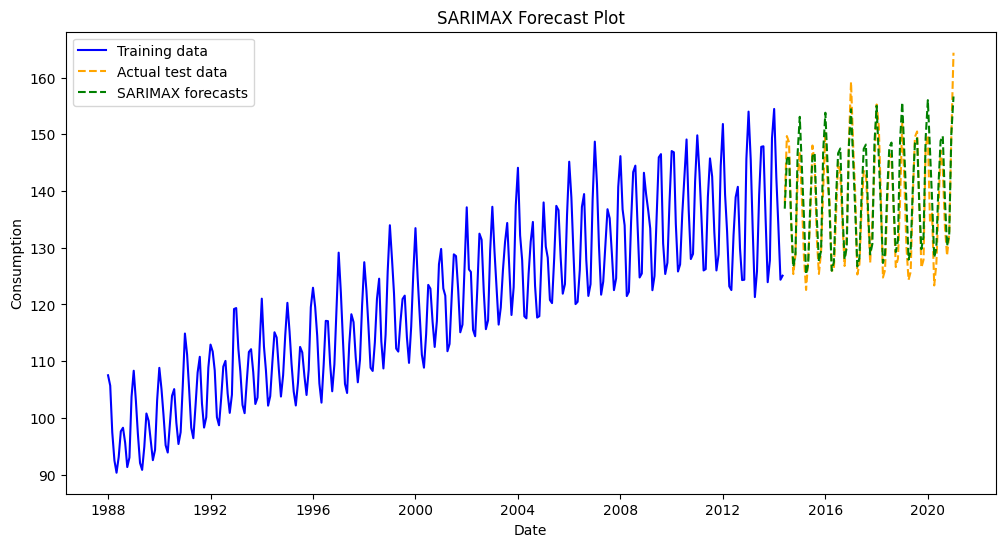

In [7]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(train['Consumption'], label='Training data', color='blue')
plt.plot(test['Consumption'], label='Actual test data', color='orange', linestyle='--')
plt.plot(forecast_values, label='SARIMAX forecasts', color='green', linestyle='--')
plt.title('SARIMAX Forecast Plot')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.legend()
plt.show()